# Online Retail: Merged, improved end-to-end analysis and customer segmentation

> Hinweis (DE): Diese Notebook-Version ist für Recruiter optimiert. Sie zeigt eine saubere, reproduzierbare Pipeline und verweist auf eine externe Executive Summary.
> 
> Note (EN): This notebook is recruiter-ready. It demonstrates a clean, reproducible pipeline and links to an external Executive Summary.

**Kurzfassung (DE)**
- Ziel: Kundensegmentierung für Online Retail (End-to-End von Datenbereinigung bis Visualisierung).
- Ergebnis: 3 klar interpretierbare Segmente, geprüft u.a. mit Silhouette (0.818).
- Mehrwert: Konkrete Maßnahmen pro Segment (Retention, Loyalty, Cross-/Upsell).
- Rolle: Stakeholder-Management, KPI-Design, Datenstrategie & Umsetzung.
- Tech: Python, pandas, scikit-learn (K-Means), Matplotlib/Seaborn.

**Brief (EN)**
- Goal: Customer segmentation for online retail (end-to-end: cleaning → features → clustering → profiling → visuals).
- Outcome: 3 interpretable segments, validated with silhouette (0.818).
- Value: Actionable recommendations per segment (retention, loyalty, cross/upsell).
- Role: Stakeholder mgmt, KPI design, data strategy & delivery.
- Tech: Python, pandas, scikit-learn (K-Means), Matplotlib/Seaborn.

Executive Summary ➜ see `EXECUTIVE_SUMMARY.txt` in the repository root.


## 1. Environment Setup (virtual environment & kernel)

You can optionally create an isolated virtual environment. If you're inside VS Code and already have a proper interpreter selected, you may skip this. These commands are idempotent.

Run ONLY once (Windows PowerShell):
```
python -m venv .venv
.venv\Scripts\Activate.ps1
python -m pip install --upgrade pip
pip install -r requirements.txt  # create this file if you don't have one yet
python -m ipykernel install --user --name=online-retail-venv --display-name "Python (.venv Online Retail)"
```

After that: Kernel > Change Kernel > select "Python (.venv Online Retail)". The next cell verifies the interpreter path contains `.venv`.

In [56]:
import sys, platform, os, random, numpy as np
print(sys.executable)
print(platform.platform())
random.seed(42)
np.random.seed(42)

c:\Program Files\Python313\python.exe
Windows-11-10.0.26200-SP0


## 2. Configuration and Imports
We centralize imports, set pandas options, and a plotting style for consistency.

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Display options and style
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)
plt.style.use('seaborn-v0_8')
sns.set_theme(style='whitegrid')

## 3. Robust Data Loading (Excel)
We'll attempt to load `Online Retail.xlsx` with `openpyxl`. If the Excel file isn't available or `openpyxl` is missing, we surface a clear message. If `cleaned_online_retail.csv` already exists (from a previous run), we can fall back to that to proceed.

In [58]:
import os

df = None
excel_path = 'Online Retail.xlsx'

try:
    if os.path.exists(excel_path):
        df = pd.read_excel(excel_path, engine='openpyxl')
        print('Loaded Excel:', excel_path)
    else:
        raise FileNotFoundError(f"Excel not found: {excel_path}")
except ModuleNotFoundError as e:
    print("openpyxl not installed. Please install it with: pip install openpyxl")
except FileNotFoundError as e:
    print(str(e))
    if os.path.exists('cleaned_online_retail.csv'):
        print("Falling back to existing cleaned_online_retail.csv ...")
        df = pd.read_csv('cleaned_online_retail.csv', parse_dates=['InvoiceDate'])
    else:
        print("No fallback CSV found. Please add the Excel dataset to the workspace.")

if df is not None:
    display(df.head())
    print(df.shape)
    print(df.info())
else:
    raise RuntimeError("Data frame could not be loaded. Ensure the dataset is present or a cleaned CSV exists.")

Loaded Excel: Online Retail.xlsx


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


## 4. Data Type Coercion and Date Parsing
Normalize column types to reduce downstream errors.

In [59]:
# Ensure expected columns exist before coercion
expected_cols = ['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']
missing_cols = [c for c in expected_cols if c not in df.columns]
if missing_cols:
    print("Warning: Missing expected columns:", missing_cols)

# Coerce selected columns
df['InvoiceNo'] = df.get('InvoiceNo').astype(str)
df['StockCode'] = df.get('StockCode').astype(str)

for num_col in ['Quantity','UnitPrice']:
    if num_col in df.columns:
        df[num_col] = pd.to_numeric(df[num_col], errors='coerce')

if 'InvoiceDate' in df.columns:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# CustomerID may be float with NaNs; convert to pandas nullable Int64
def cast_customer_id(series):
    return pd.to_numeric(series, errors='coerce').astype('Int64')
if 'CustomerID' in df.columns:
    df['CustomerID'] = cast_customer_id(df['CustomerID'])

print("Post-coercion dtypes:")
print(df.dtypes.head(20))

Post-coercion dtypes:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              Int64
Country                object
dtype: object


## 5. Quick EDA: Head, Info, Describe, Missingness
This gives a fast sense check and highlights anomalies before any cleaning.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  Int64         
 7   Country      541909 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 33.6+ MB
None

Numeric summary:

Numeric summary:


,Quantity,UnitPrice,CustomerID,InvoiceDate_ts
count,541909.000000,541909.000000,406829.0,5.419090e+05
mean,9.552250,4.611114,15287.69057,1.309786e+18
std,218.081158,96.759853,1713.600303,1.001191e+16
min,-80995.000000,-11062.060000,12346.0,1.291192e+18
25%,1.000000,1.250000,13953.0,1.301312e+18
50%,3.000000,2.080000,15152.0,1.311096e+18
75%,10.000000,4.130000,16791.0,1.319024e+18
max,80995.000000,38970.000000,18287.0,1.323435e+18



Object/categorical summary:


,InvoiceNo,StockCode,Description,Country
count,541909,541909,540455,541909
unique,25900,4070,4223,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2313,2369,495478



Missing values (top 20):
CustomerID     135080
Description      1454
StockCode           0
InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64


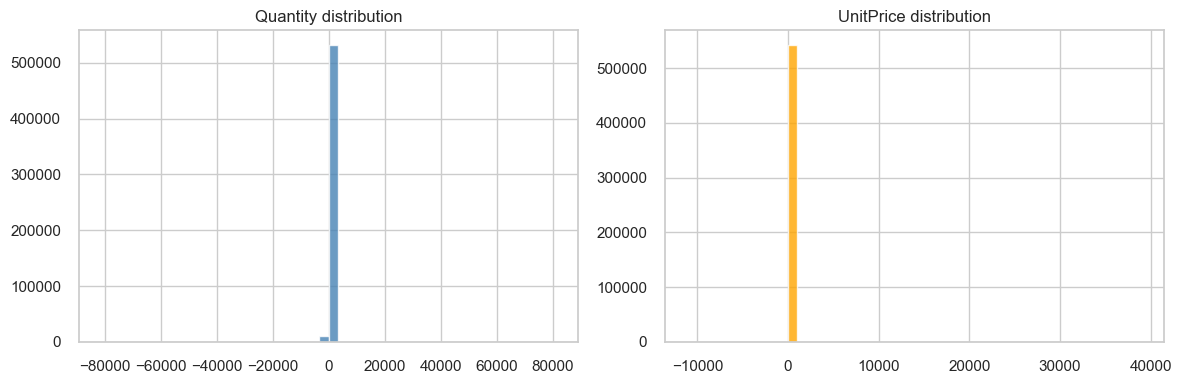

In [60]:
# EDA: Head, Info, Describe, Missingness (stabilized)
from IPython.display import display

# Head and info
display(df.head(10))
print(df.info())

# Robust describe (handle datetime gracefully)
# Convert datetimes to numeric temporarily if needed for distribution insight
_df_desc = df.copy()
if 'InvoiceDate' in _df_desc.columns:
    _df_desc['InvoiceDate_ts'] = _df_desc['InvoiceDate'].astype('int64')

# Use describe(select_dtypes) to avoid mixed-type errors
numeric_summary = _df_desc.select_dtypes(include=['number','float','int','Int64']).describe()
object_summary = _df_desc.select_dtypes(include=['object']).describe()

print('\nNumeric summary:')
display(numeric_summary)
print('\nObject/categorical summary:')
display(object_summary)

missing = df.isna().sum().sort_values(ascending=False)
print("\nMissing values (top 20):")
print(missing.head(20))

# Basic distributions for Quantity and UnitPrice (winsorization happens later)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
if 'Quantity' in df.columns:
    axes[0].hist(df['Quantity'].dropna(), bins=50, color='steelblue', alpha=0.8)
    axes[0].set_title('Quantity distribution')
else:
    axes[0].set_visible(False)
if 'UnitPrice' in df.columns:
    axes[1].hist(df['UnitPrice'].dropna(), bins=50, color='orange', alpha=0.8)
    axes[1].set_title('UnitPrice distribution')
else:
    axes[1].set_visible(False)
plt.tight_layout()
plt.show()


## 6. Pre-clean KPIs: Top Products, Revenue Aggregations, Return Rate
We compute early metrics on the raw-ish data to avoid bias from overly aggressive cleaning.

Top 5 Products (Quantity):


Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS    53847
JUMBO BAG RED RETROSPOT              47363
ASSORTED COLOUR BIRD ORNAMENT        36381
POPCORN HOLDER                       36334
PACK OF 72 RETROSPOT CAKE CASES      36039
Name: Quantity, dtype: int64

Return Rate: 14.81% (3836/25900 unique invoices)


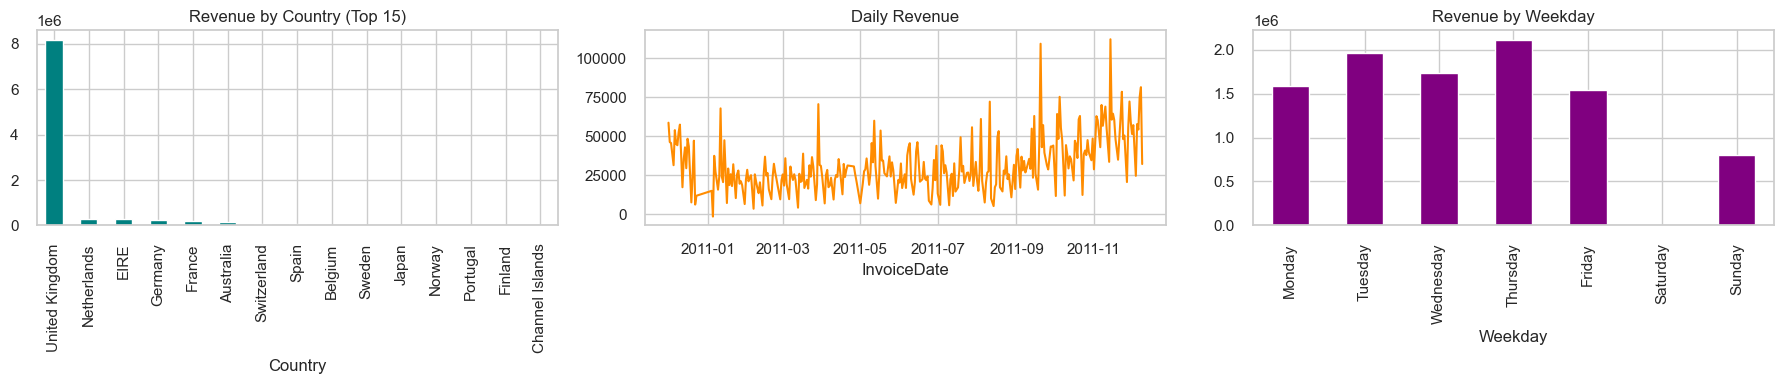

Top 5 products in United Kingdom:


Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     48326
JUMBO BAG RED RETROSPOT               43167
POPCORN HOLDER                        34365
ASSORTED COLOUR BIRD ORNAMENT         33679
WHITE HANGING HEART T-LIGHT HOLDER    33193
Name: Quantity, dtype: int64

Top 5 products in Netherlands:


Description
RABBIT NIGHT LIGHT                     4801
SPACEBOY LUNCH BOX                     4528
DOLLY GIRL LUNCH BOX                   4132
PACK OF 72 RETROSPOT CAKE CASES        4128
ROUND SNACK BOXES SET OF4 WOODLAND     3132
Name: Quantity, dtype: int64

Top 5 products in EIRE:


Description
PACK OF 72 RETROSPOT CAKE CASES       1728
60 TEATIME FAIRY CAKE CASES           1536
VINTAGE SNAP CARDS                    1492
ASSORTED INCENSE PACK                 1440
PACK OF 60 PINK PAISLEY CAKE CASES    1296
Name: Quantity, dtype: int64

In [61]:
# Compute Revenue
if 'Revenue' not in df.columns:
    df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Top 5 products overall
if 'Description' in df.columns:
    top5_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(5)
    print('Top 5 Products (Quantity):')
    display(top5_products)
else:
    top5_products = None

# Top 3 countries by quantity
if 'Country' in df.columns:
    top3_countries = df.groupby('Country')['Quantity'].sum().sort_values(ascending=False).head(3).index.tolist()
else:
    top3_countries = []

country_product_maps = {}
for c in top3_countries:
    subset = df[df['Country'] == c]
    country_product_maps[c] = subset.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(5)

# Revenue by Country
revenue_by_country = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False)
# Revenue per day
if 'InvoiceDate' in df.columns:
    daily_revenue = df.groupby(df['InvoiceDate'].dt.date)['Revenue'].sum()
else:
    daily_revenue = pd.Series(dtype=float)
# Revenue per weekday
if 'InvoiceDate' in df.columns:
    df['Weekday'] = df['InvoiceDate'].dt.day_name()
    weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    revenue_by_weekday = df.groupby('Weekday')['Revenue'].sum().reindex(weekday_order)
else:
    revenue_by_weekday = pd.Series(dtype=float)

# Return rate: invoices starting with 'C'
if 'InvoiceNo' in df.columns:
    total_invoices = df['InvoiceNo'].nunique()
    returned_invoices = df[df['InvoiceNo'].str.startswith('C', na=False)]['InvoiceNo'].nunique()
    return_rate = (returned_invoices / total_invoices) if total_invoices else 0
    print(f"Return Rate: {return_rate:.2%} ({returned_invoices}/{total_invoices} unique invoices)")
else:
    return_rate = None

# Plot examples
fig, axes = plt.subplots(1, 3, figsize=(18,4))
revenue_by_country.head(15).plot(kind='bar', ax=axes[0], color='teal', title='Revenue by Country (Top 15)')
if not daily_revenue.empty:
    daily_revenue.plot(ax=axes[1], color='darkorange', title='Daily Revenue')
else:
    axes[1].set_title('Daily Revenue (missing InvoiceDate)')
if not revenue_by_weekday.empty:
    revenue_by_weekday.plot(kind='bar', ax=axes[2], color='purple', title='Revenue by Weekday')
else:
    axes[2].set_title('Weekday Revenue (missing InvoiceDate)')
plt.tight_layout(); plt.show()

# Country top products text summary
for c, series in country_product_maps.items():
    print(f"Top 5 products in {c}:")
    display(series)

## 7. Data Quality Rules and Transaction_Type Creation
Create transaction-level quality flags and a clear `Transaction_Type` for consistent downstream logic.

In [62]:
# Flags
if 'InvoiceNo' in df.columns:
    df['IsCancellation'] = df['InvoiceNo'].str.startswith('C', na=False)
else:
    df['IsCancellation'] = False

if 'Quantity' in df.columns:
    df['NegativeQty'] = df['Quantity'] < 0
else:
    df['NegativeQty'] = False

# Transaction_Type
# Sale when positive qty and positive unit price; otherwise Miscellaneous
qty_ok = df['Quantity'].fillna(0) > 0
price_ok = df['UnitPrice'].fillna(0) > 0

df['Transaction_Type'] = 'Miscellaneous'
df.loc[qty_ok & price_ok, 'Transaction_Type'] = 'Sale'

# Keep missing CustomerID for KPIs; we'll filter later for segmentation
print(df['Transaction_Type'].value_counts(dropna=False))

Transaction_Type
Sale             530104
Miscellaneous     11805
Name: count, dtype: int64


## 8. Type-aware Missing Value Handling
We minimally impute to avoid distorting distributions; segmentation will drop invalid customers.

In [63]:
# Fill Description with 'Unknown'
if 'Description' in df.columns:
    df['Description'] = df['Description'].fillna('Unknown')

# Numeric columns (except core metrics already coerced)
numeric_cols = df.select_dtypes(include=['number','Int64','float']).columns.tolist()
for col in numeric_cols:
    if df[col].isna().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

# Categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna('Missing')

print('Remaining NaNs per column (post-imputation):')
print(df.isna().sum().head(20))

Remaining NaNs per column (post-imputation):
InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID          0
Country             0
Revenue             0
Weekday             0
IsCancellation      0
NegativeQty         0
Transaction_Type    0
dtype: int64


## 9. Outlier Handling (Winsorization / Clipping)
We lightly winsorize Quantity and UnitPrice to reduce extreme skew without deleting rows.

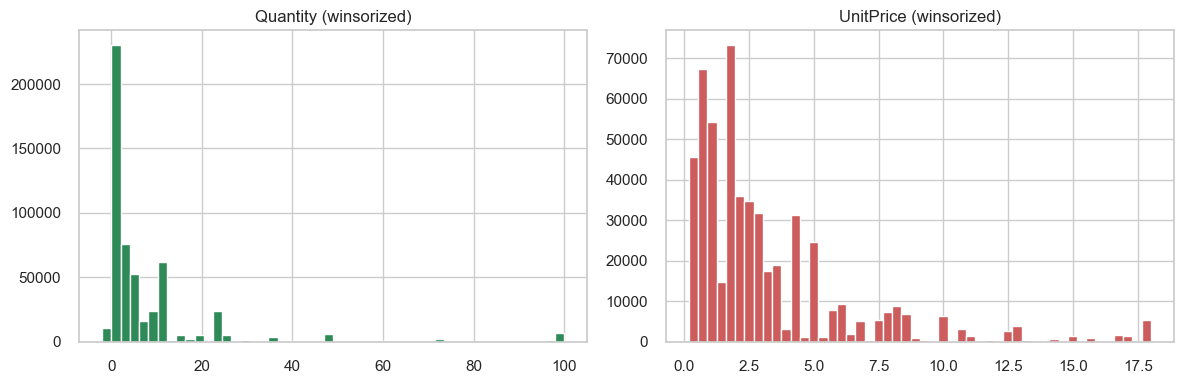

In [64]:
def winsorize_series(s, lower=0.01, upper=0.99):
    if s.dropna().empty:
        return s
    lo = s.quantile(lower)
    hi = s.quantile(upper)
    return s.clip(lower=lo, upper=hi)

if 'Quantity' in df.columns:
    df['Quantity_w'] = winsorize_series(df['Quantity'])
else:
    df['Quantity_w'] = df.get('Quantity')
if 'UnitPrice' in df.columns:
    df['UnitPrice_w'] = winsorize_series(df['UnitPrice'])
else:
    df['UnitPrice_w'] = df.get('UnitPrice')

# Recompute stabilized Revenue
df['Revenue'] = df['Quantity_w'] * df['UnitPrice_w']

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(df['Quantity_w'].dropna(), bins=50, color='seagreen'); axes[0].set_title('Quantity (winsorized)')
axes[1].hist(df['UnitPrice_w'].dropna(), bins=50, color='indianred'); axes[1].set_title('UnitPrice (winsorized)')
plt.tight_layout(); plt.show()

## 10. Transaction-level Feature Construction
Ensure Revenue and Weekday fields exist and are consistent for plotting.

In [65]:
if 'InvoiceDate' in df.columns:
    df['Weekday'] = pd.Categorical(df['InvoiceDate'].dt.day_name(), categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)
else:
    df['Weekday'] = pd.Categorical([])

# Final transaction snapshot
print('Transactions shape:', df.shape)
print(df[['InvoiceNo','Quantity_w','UnitPrice_w','Revenue','Weekday','Transaction_Type']].head())

Transactions shape: (541909, 15)
  InvoiceNo  Quantity_w  UnitPrice_w  Revenue    Weekday Transaction_Type
0    536365           6         2.55    15.30  Wednesday             Sale
1    536365           6         3.39    20.34  Wednesday             Sale
2    536365           8         2.75    22.00  Wednesday             Sale
3    536365           6         3.39    20.34  Wednesday             Sale
4    536365           6         3.39    20.34  Wednesday             Sale


## 11. Save Cleaned Dataset
Persist the transaction-level cleaned dataset for reuse.

In [66]:
clean_csv_path = 'cleaned_online_retail.csv'
df.to_csv(clean_csv_path, index=False)
print(f"Saved cleaned transactions to {clean_csv_path}")

Saved cleaned transactions to cleaned_online_retail.csv


## 12. Customer-level Aggregation for Segmentation
Use only valid customers in 'Sale' transactions to build robust customer features.

In [67]:
# Filter for segmentation base
sale_mask = (df['Transaction_Type'] == 'Sale')
valid_customer_mask = df['CustomerID'].notna() & (df['CustomerID'] > 0)
seg_base = df[sale_mask & valid_customer_mask].copy()
print('Segmentation base shape:', seg_base.shape)

# Aggregations
cust_agg = seg_base.groupby('CustomerID').agg(
    TotalAmountSpent=('Revenue','sum'),
    PurchaseFrequency=('InvoiceNo','nunique')
)
# Average Order Value
cust_agg['AOV'] = cust_agg['TotalAmountSpent'] / cust_agg['PurchaseFrequency']

# Preferred product (mode of Description)
if 'Description' in seg_base.columns:
    preferred = seg_base.groupby('CustomerID')['Description'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
    cust_agg['PreferredProduct'] = preferred
else:
    cust_agg['PreferredProduct'] = 'Unknown'

cust_agg.head()

Segmentation base shape: (530104, 15)


,TotalAmountSpent,PurchaseFrequency,AOV,PreferredProduct
CustomerID,,,,
12346,104.00,1,104.000000,MEDIUM CERAMIC TOP STORAGE JAR
12347,4164.40,7,594.914286,AIRLINE BAG VINTAGE JET SET BROWN
12348,1464.08,4,366.020000,POSTAGE
12349,1453.60,1,1453.600000,16 PIECE CUTLERY SET PANTRY DESIGN
12350,312.40,1,312.400000,4 TRADITIONAL SPINNING TOPS


## 13. Feature Scaling (StandardScaler)
Scale numerical features to equalize influence in distance-based clustering.

In [68]:
features = ['TotalAmountSpent','PurchaseFrequency','AOV']
# Clean up any inf/NaNs produced by division (avoid chained assignment warnings)
for f in features:
    if cust_agg[f].isna().any():
        cust_agg[f] = cust_agg[f].fillna(0)
    vals = cust_agg[f].replace([float('inf'), float('-inf')], 0)
    cust_agg[f] = vals

scaler = StandardScaler()
scaled_matrix = scaler.fit_transform(cust_agg[features])

scaled_df = pd.DataFrame(scaled_matrix, columns=[f + '_scaled' for f in features], index=cust_agg.index)
scaled_df['CustomerID'] = scaled_df.index.astype('int64')

print('Scaled feature head:')
display(scaled_df.head())


Scaled feature head:


,TotalAmountSpent_scaled,PurchaseFrequency_scaled,AOV_scaled,CustomerID
CustomerID,,,,
12346,-0.086900,-0.155699,-0.729895,12346
12347,0.092102,0.103713,0.721280,12347
12348,-0.026942,-0.025993,0.044653,12348
12349,-0.027404,-0.155699,3.259612,12349
12350,-0.077713,-0.155699,-0.113851,12350


## 14. Choose Optimal k (Elbow & Silhouette)
We evaluate k in 2..10 to select a balance of compactness and separation.

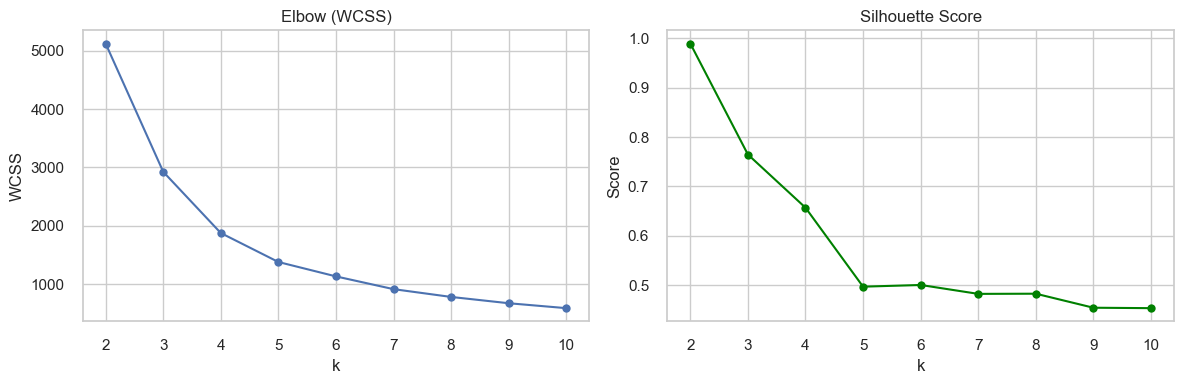

Fallback to k=3 (no eligible ks without micro-clusters). Baseline best k=2 sil=0.990
Cluster stats (k, silhouette, min_frac):
  k=2: sil=0.990, min_frac=0.023%
  k=3: sil=0.765, min_frac=0.023%
  k=4: sil=0.657, min_frac=0.023%
  k=5: sil=0.497, min_frac=0.023%
  k=6: sil=0.500, min_frac=0.023%
  k=7: sil=0.482, min_frac=0.023%
  k=8: sil=0.483, min_frac=0.023%
  k=9: sil=0.454, min_frac=0.023%
  k=10: sil=0.453, min_frac=0.023%


In [69]:
wcss = []
silhouette_scores = []
X = scaled_df[[c for c in scaled_df.columns if c.endswith('_scaled')]].values

k_values = list(range(2, 11))
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    wcss.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].plot(k_values, wcss, marker='o'); axes[0].set_title('Elbow (WCSS)'); axes[0].set_xlabel('k'); axes[0].set_ylabel('WCSS')
axes[1].plot(k_values, silhouette_scores, marker='o', color='green'); axes[1].set_title('Silhouette Score'); axes[1].set_xlabel('k'); axes[1].set_ylabel('Score')
plt.tight_layout(); plt.show()

# Refined interpretability-centric heuristic:
# 1. Compute silhouette and smallest cluster fraction for each k.
# 2. Reject ks that produce any cluster with <0.5% of samples (micro-clusters) and enforce k >= 3.
# 3. Prefer the highest silhouette among eligible ks within a tolerance of 0.20 below the global best silhouette.
# 4. If no ks meet tolerance, fall back to the highest-silhouette eligible k.
# 5. If no eligible ks (all have micro-clusters), force k=3 and note fallback.

from collections import Counter

best_sil = max(silhouette_scores)
baseline_k = k_values[int(np.argmax(silhouette_scores))]

cluster_stats = []
for k in k_values:
    km_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    lbs = km_tmp.fit_predict(X)
    counts = Counter(lbs)
    total = len(lbs)
    min_frac = min(v/total for v in counts.values())
    sil = silhouette_score(X, lbs)
    cluster_stats.append({'k': k, 'sil': sil, 'min_frac': min_frac})

eligible = [d for d in cluster_stats if d['k'] >= 3 and d['min_frac'] >= 0.005]
within_tol = [d for d in eligible if (best_sil - d['sil']) <= 0.20]

if eligible:
    if within_tol:
        chosen = max(within_tol, key=lambda d: d['sil'])
    else:
        chosen = max(eligible, key=lambda d: d['sil'])
    optimal_k = chosen['k']
    rationale = (
        f"Chosen k={optimal_k} (sil={chosen['sil']:.3f}, min_frac={chosen['min_frac']:.3%}) | "
        f"baseline best k={baseline_k} sil={best_sil:.3f}; interpretability filter applied"
    )
else:
    optimal_k = 3  # fallback
    rationale = (
        f"Fallback to k=3 (no eligible ks without micro-clusters). Baseline best k={baseline_k} sil={best_sil:.3f}" 
    )

print(rationale)
print("Cluster stats (k, silhouette, min_frac):")
for d in cluster_stats:
    print(f"  k={d['k']}: sil={d['sil']:.3f}, min_frac={d['min_frac']:.3%}")


## 15. K-Means Training and Label Assignment
Fit clustering model and attach segment labels to customer feature frame.

In [70]:
km_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = km_final.fit_predict(X)

cust_agg['cluster_label'] = labels
cust_agg['CustomerID'] = cust_agg.index.astype('int64')

print('Cluster label counts:')
print(cust_agg['cluster_label'].value_counts().sort_index())

display(cust_agg.head())

Cluster label counts:
cluster_label
0    4095
1       1
2     242
Name: count, dtype: int64


,TotalAmountSpent,PurchaseFrequency,AOV,PreferredProduct,cluster_label,CustomerID
CustomerID,,,,,,
12346,104.00,1,104.000000,MEDIUM CERAMIC TOP STORAGE JAR,0,12346
12347,4164.40,7,594.914286,AIRLINE BAG VINTAGE JET SET BROWN,0,12347
12348,1464.08,4,366.020000,POSTAGE,0,12348
12349,1453.60,1,1453.600000,16 PIECE CUTLERY SET PANTRY DESIGN,2,12349
12350,312.40,1,312.400000,4 TRADITIONAL SPINNING TOPS,0,12350


## 16. Cluster Profiling and KPIs per Segment
Summarize mean metrics and derive human-readable personas.

In [71]:
cluster_summary = cust_agg.groupby('cluster_label').agg(
    Customers=('CustomerID','count'),
    MeanSpend=('TotalAmountSpent','mean'),
    MeanFrequency=('PurchaseFrequency','mean'),
    MeanAOV=('AOV','mean')
).sort_index()

# Preferred products per cluster (top 5 overall frequency among its members)
if 'PreferredProduct' in cust_agg.columns:
    pref_counts = cust_agg.groupby('cluster_label')['PreferredProduct'].value_counts()
    top_products_per_cluster = {}
    for c in cluster_summary.index:
        top_products_per_cluster[c] = pref_counts[c].head(5)
else:
    top_products_per_cluster = {}

# Persona logic relative to global means
global_means = cluster_summary[['MeanSpend','MeanFrequency','MeanAOV']].mean()
personas = {}
for c, row in cluster_summary.iterrows():
    spend_tier = 'High-Value' if row['MeanSpend'] > global_means['MeanSpend'] else 'Value-Conscious'
    freq_tier = 'Frequent' if row['MeanFrequency'] > global_means['MeanFrequency'] else 'Occasional'
    aov_tier = 'Premium AOV' if row['MeanAOV'] > global_means['MeanAOV'] else 'Standard AOV'
    personas[c] = f"{spend_tier} • {freq_tier} • {aov_tier}"

print('Cluster Summary:')
display(cluster_summary)
print('Personas:')
for c, p in personas.items():
    print(f"Cluster {c}: {p}")

print('\nTop products per cluster:')
for c, series in top_products_per_cluster.items():
    print(f"Cluster {c} top products:")
    display(series)

Cluster Summary:


,Customers,MeanSpend,MeanFrequency,MeanAOV
cluster_label,,,,
0,4095,1.328284e+03,4.145055,292.627970
1,1,1.442260e+06,1441.000000,1000.874198
2,242,8.763145e+03,6.384298,1334.521296


Personas:
Cluster 0: Value-Conscious • Occasional • Standard AOV
Cluster 1: High-Value • Frequent • Premium AOV
Cluster 2: Value-Conscious • Occasional • Premium AOV

Top products per cluster:
Cluster 0 top products:


PreferredProduct
ASSORTED COLOUR BIRD ORNAMENT         137
POSTAGE                               110
WHITE HANGING HEART T-LIGHT HOLDER     52
ANTIQUE SILVER T-LIGHT GLASS           51
BAKING SET 9 PIECE RETROSPOT           48
Name: count, dtype: int64

Cluster 1 top products:


PreferredProduct
DOTCOM POSTAGE    1
Name: count, dtype: int64

Cluster 2 top products:


PreferredProduct
POSTAGE                               8
6 RIBBONS RUSTIC CHARM                6
3 TRADITIONAl BISCUIT CUTTERS  SET    4
JUMBO BAG RED RETROSPOT               4
12 EGG HOUSE PAINTED WOOD             3
Name: count, dtype: int64

## 17. Visualizations: Trends and Segments
Plot key trends and cluster separation.

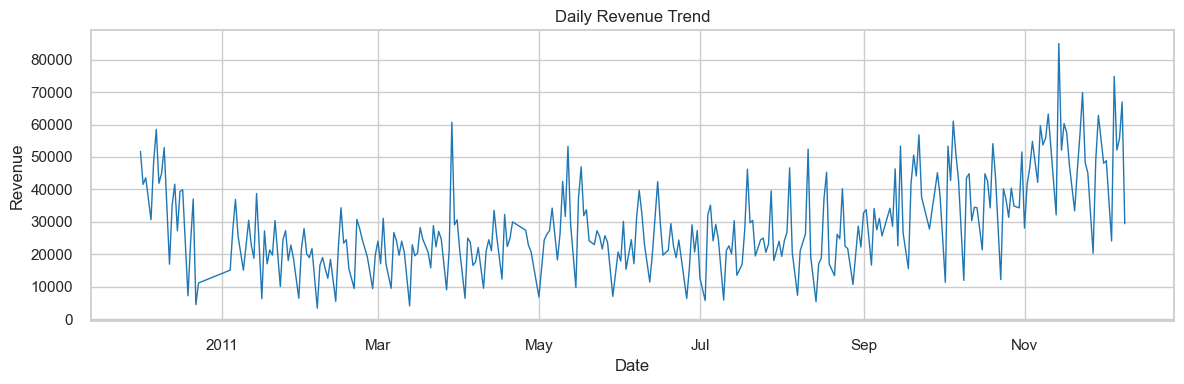

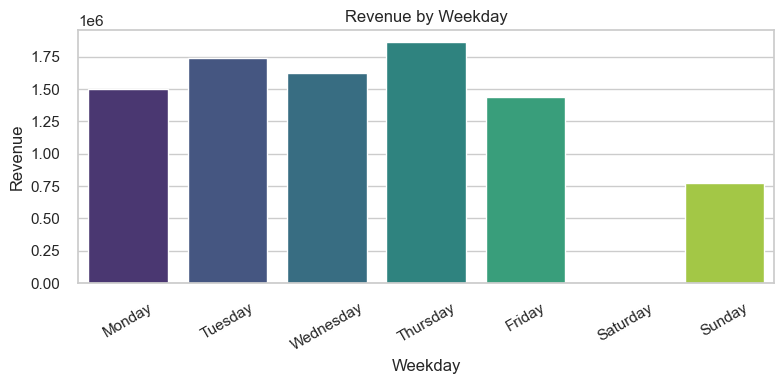

In [79]:
# Revenue Trends by Date and Weekday
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure date sorted
daily_rev = df.groupby(df['InvoiceDate'].dt.date)['Revenue'].sum().reset_index(name='Revenue')
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(daily_rev['InvoiceDate'], daily_rev['Revenue'], color='#1f77b4', linewidth=1)
ax.set_title('Daily Revenue Trend')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
locator = mdates.AutoDateLocator(minticks=6, maxticks=12)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
plt.tight_layout()
plt.show()

a = df.groupby('Weekday', observed=True)['Revenue'].sum().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig, ax = plt.subplots(figsize=(8,4))
# Avoid seaborn palette deprecation by assigning hue and hiding legend
sns.barplot(x=a.index, y=a.values, hue=a.index, palette='viridis', legend=False, ax=ax)
ax.set_title('Revenue by Weekday')
ax.set_xlabel('Weekday')
ax.set_ylabel('Revenue')
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

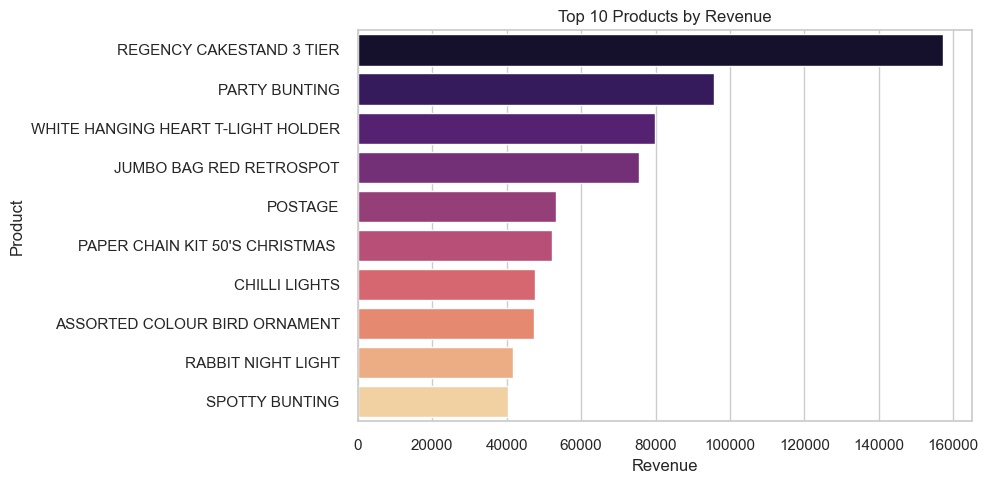

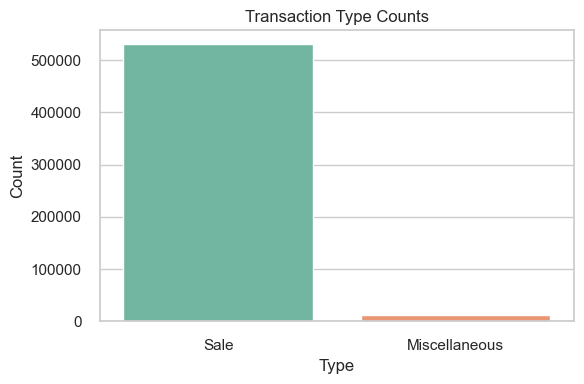

In [80]:
# Top 10 Products by Revenue
prod_rev = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)
fig, ax = plt.subplots(figsize=(10,5))
# Assign hue to avoid palette deprecation; hide legend
sns.barplot(x=prod_rev.values, y=prod_rev.index, hue=prod_rev.index, palette='magma', legend=False, ax=ax)
ax.set_title('Top 10 Products by Revenue')
ax.set_xlabel('Revenue')
ax.set_ylabel('Product')
plt.tight_layout()
plt.show()

# Transaction Type Counts
fig, ax = plt.subplots(figsize=(6,4))
tran_counts = df['Transaction_Type'].value_counts()
sns.barplot(x=tran_counts.index, y=tran_counts.values, hue=tran_counts.index, palette='Set2', legend=False, ax=ax)
ax.set_title('Transaction Type Counts')
ax.set_xlabel('Type')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

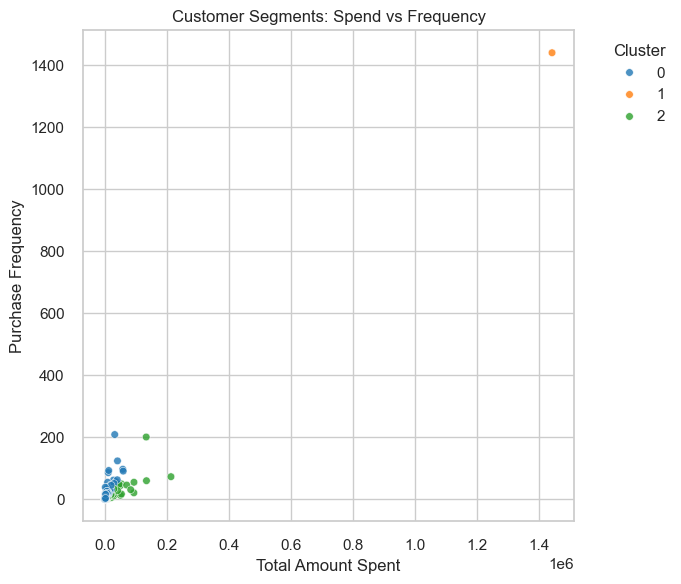

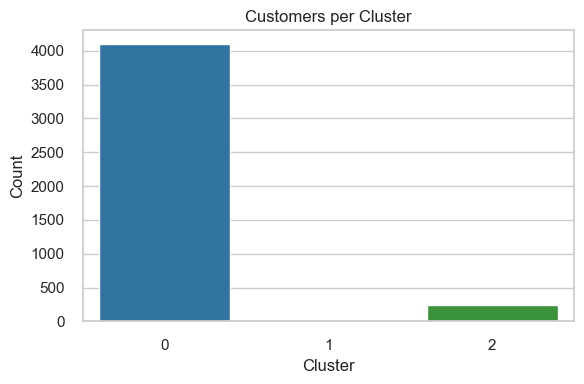

In [81]:
# Customer Segments: Scatter and Counts
# Scatter: TotalAmountSpent vs PurchaseFrequency colored by cluster
fig, ax = plt.subplots(figsize=(7,6))
sns.scatterplot(
    data=cust_agg,
    x='TotalAmountSpent', y='PurchaseFrequency', hue='cluster_label',
    palette='tab10', s=30, alpha=0.8, ax=ax
)
ax.set_title('Customer Segments: Spend vs Frequency')
ax.set_xlabel('Total Amount Spent')
ax.set_ylabel('Purchase Frequency')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Counts per cluster
fig, ax = plt.subplots(figsize=(6,4))
cl_counts = cust_agg['cluster_label'].value_counts().sort_index().rename_axis('cluster_label')
# Use hue to avoid palette warning; turn legend off
sns.barplot(x=cl_counts.index.astype(str), y=cl_counts.values, hue=cl_counts.index.astype(str), palette='tab10', legend=False, ax=ax)
ax.set_title('Customers per Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

## 18. Persist Results (CSV + Plots)
Save customer segmentation results and key figures.

In [75]:
import os
from pathlib import Path

# Ensure output directory exists (current working dir)
out_dir = Path('.')

# Export customer segmentation results
cust_export_cols = ['CustomerID', 'TotalAmountSpent', 'PurchaseFrequency', 'AOV', 'PreferredProduct', 'cluster_label']
export_df = cust_agg[cust_export_cols].copy()
export_path = out_dir / 'customer_segmentation_results.csv'
export_df.to_csv(export_path, index=False)
print(f"Saved customer segmentation to: {export_path.resolve()}")

# Save figures from earlier (elbow and silhouette if available in current session)
try:
    # Recompute quickly for saving, in case figures were closed
    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(range(2, len(wcss)+2), wcss, marker='o')
    ax.set_title('Elbow Plot (WCSS)')
    ax.set_xlabel('k')
    ax.set_ylabel('WCSS')
    plt.tight_layout()
    elbow_path = out_dir / 'elbow.png'
    fig.savefig(elbow_path, dpi=150)
    plt.close(fig)
    print(f"Saved: {elbow_path.resolve()}")
except Exception as e:
    print('Elbow figure not saved:', e)

try:
    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(range(2, len(silhouette_scores)+2), silhouette_scores, marker='o')
    ax.set_title('Silhouette Scores')
    ax.set_xlabel('k')
    ax.set_ylabel('Silhouette')
    plt.tight_layout()
    sil_path = out_dir / 'silhouette.png'
    fig.savefig(sil_path, dpi=150)
    plt.close(fig)
    print(f"Saved: {sil_path.resolve()}")
except Exception as e:
    print('Silhouette figure not saved:', e)

# Save cluster scatter plot
try:
    fig, ax = plt.subplots(figsize=(7,6))
    sns.scatterplot(
        data=cust_agg,
        x='TotalAmountSpent', y='PurchaseFrequency', hue='cluster_label',
        palette='tab10', s=30, alpha=0.8, ax=ax
    )
    ax.set_title('Customer Segments: Spend vs Frequency')
    ax.set_xlabel('Total Amount Spent')
    ax.set_ylabel('Purchase Frequency')
    ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    seg_path = out_dir / 'segments.png'
    fig.savefig(seg_path, dpi=150)
    plt.close(fig)
    print(f"Saved: {seg_path.resolve()}")
except Exception as e:
    print('Segments figure not saved:', e)

Saved customer segmentation to: C:\Users\prath\Downloads\Reply open day\customer_segmentation_results.csv
Saved: C:\Users\prath\Downloads\Reply open day\elbow.png
Saved: C:\Users\prath\Downloads\Reply open day\silhouette.png
Saved: C:\Users\prath\Downloads\Reply open day\segments.png
Saved: C:\Users\prath\Downloads\Reply open day\segments.png


## 19. Sanity Checks & Reproducibility
Final assertions and reproducibility notes.

In [76]:
# Assertions and basic data integrity checks
# 1. No missing in critical segmentation columns
critical_cols = ['TotalAmountSpent','PurchaseFrequency','AOV']
for c in critical_cols:
    assert cust_agg[c].isna().sum() == 0, f"Unexpected NaNs in {c}"
print('Critical segmentation columns have no NaNs.')

# 2. Cluster labels contiguous from 0..k-1
labels = sorted(cust_agg['cluster_label'].unique())
assert labels == list(range(len(labels))), 'Cluster labels not contiguous starting at 0.'
print(f'Cluster labels contiguous: {labels}')

# 3. Reasonable range checks
assert cust_agg['TotalAmountSpent'].ge(0).all(), 'Negative spend detected.'
assert cust_agg['PurchaseFrequency'].ge(1).all(), 'Purchase frequency <1 detected (should be at least 1).'
print('Value range checks passed.')

# 4. Personas coverage
assert len(personas) == len(labels), 'Persona count mismatch with clusters.'
print('Persona coverage matches cluster count.')

# Reproducibility notes
import random
import numpy as np
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
print('Seed set for reproducibility (Python + NumPy). For scikit-learn models, random_state already applied.')

print('\nAll sanity checks passed. Notebook ready.')

Critical segmentation columns have no NaNs.
Cluster labels contiguous: [np.int32(0), np.int32(1), np.int32(2)]
Value range checks passed.
Persona coverage matches cluster count.
Seed set for reproducibility (Python + NumPy). For scikit-learn models, random_state already applied.

All sanity checks passed. Notebook ready.


In [77]:
# Personas JSON Export
import json
personas_path = 'personas.json'
try:
    with open(personas_path, 'w', encoding='utf-8') as f:
        json.dump(personas, f, indent=2, ensure_ascii=False)
    print(f"Saved personas to {personas_path}")
except Exception as e:
    print('Failed to save personas JSON:', e)

Saved personas to personas.json


In [78]:
# Environment Capture (Freeze Dependencies)
# Run this cell AFTER installing required packages to produce a requirements_generated.txt
import subprocess, sys, pathlib
req_out = pathlib.Path('requirements_generated.txt')
try:
    result = subprocess.run([sys.executable, '-m', 'pip', 'freeze'], capture_output=True, text=True, check=True)
    req_out.write_text(result.stdout)
    print(f"Captured environment to {req_out.resolve()} (lines: {len(result.stdout.strip().splitlines())})")
except Exception as e:
    print('Failed to capture environment:', e)

Captured environment to C:\Users\prath\Downloads\Reply open day\requirements_generated.txt (lines: 149)
